In [134]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math

# Number of cycles to run the simulation for
cycles = 100

# Knobs that can be turned on individual nests
"""##################################################################################################
Unused globals, whoops
##################################################################################################"""
startingPop                 = 10    # Starting population of a nest, not used

"""##################################################################################################
Chicken generation levers, controls chicken base stats before lineage factored in
##################################################################################################"""
maleChance                  = 0.50  # Chance of male rooster hatching
startingSpeed               = 0.10  # Decreases the chance that a chicken will die crossing the
                                    # road
startingAggression          = 0.10  # Starting aggression rate, factors into fitness. At high 
                                    # aggression a chicken has a chance to kill another chicken

"""##################################################################################################
Breed levers, controls breeding levels and chicken murder
##################################################################################################"""
chanceOfMovingIfNotBred     = 0.75  # Chance that a chicken will leave the nest if it can't breed
chanceFertilizedEgg         = 0.40  # Chance that an egg will be fertilized in a cycle. Fertilized
                                    # eggs generate new pops
maxAge                      = 10     # Age at which chickens die of natural causes
henFertileAge               = 10     # Age at which hens stop producing eggs. They are still 
                                    # factored into breeding systems, but do not lay fertilized eggs
hensImpregnatedPerRooster   = 1     # Number of hens that a rooster can impregnate in a single cycle


"""##################################################################################################
Food levers, control your population through starvation. The Great Cluck Forwards!
##################################################################################################"""
startingFood                = 0.50  # Percentage of the maximum food that a nest starts with
foodGain                    = 1.00  # Percentage of the maximum food that a nest gets back at the
                                    # start of each cycle (after starvation checks and other stuff)
foodPerRooster              = 1.0   # Food consumed by roosters each cycle
foodPerHen                  = 1.0   # Food consumed by hens each cycle
roosterStarveModifier       = 0.75  # Modifies the chance a rooster will starve, chance * modifier
henStarveModifier           = 1.00  # Modifies the chance a hen will starve, chance * modifier
                                    # base chance to starve is the deficit of food/maxfood
maxFoodIncrease             = 0.01  # The amount that a nest's maximum food is increased when
                                    # chickens don't eat all available food
maxFoodDecrease             = 0.15  # Percentage that a nest's maximum food is decreased when
                                    # chickens don't eat all available food
feastAggressionChange       = 0.01  # When there is enough food for all pops to eat, decrease a 
                                    # chickens aggression by this value due to a lack of competition.
                                    # This value should be positive. aggression + (value * -1)
famineAggressionChange      = 0.03  # When there is a food scarcity, increase aggression by this 
                                    # amount due to the competition for resources
                                    # This value should be positive, aggression + value

"""##################################################################################################
Fitness levers, determines rooster breeding order
##################################################################################################"""
speedWeight                 = 3.00  # Percentage of speed that is factored into breeding fitness
aggressionWeight            = 0.50  # Percentage of aggression that is factored into breeding
henBreedingAggression       = 0.005 # When a hen breeds, their aggression is increased by this amount
roosterBreedingAggression   = 0.005 # When a rooster breads, their aggression is increased by this
                                    # amount
speedForRoadCrossing        = 0.015  # When a chicken crosses the road, their speed is increased by
                                    # amount
murderousAggression         = 0.50  # Average aggression level at which a nest will suffer from
                                    # infighting. Infighting has a chance of killing off pops and
                                    # lowers the overall aggression of each surviving bird to a 
                                    # percentage of their current aggression.
postMurderAggression        = 0.33  # Percentage that a surviving chickens aggression level is
                                    # lowered to
baseChanceToDieInCombat     = 0.60  # Base chance that any given chicken will die from a war of
                                    # aggression. Formula for death chance is:
                                    # baseChance - (speed)



In [135]:
# Information need to graph data, each cycle a nest updates this information.
class GraphData():
    def __init__(self, rPop, hPop, nFood, cFood):
        self.rData      = [rPop]                    # Rooster population
        self.hData      = [hPop]                    # Hen population
        self.tData      = [rPop + hPop]             # Total population
        self.nFood      = [nFood]                   # Needed food
        self.cFood      = [cFood]                   # Current food
        self.agAve      = [startingAggression]      # Nests average aggression
        self.spAve      = [startingSpeed]           # Nests average speed

    def updatePopulationData(self, rPop, hPop):
        self.rData.append(rPop)
        self.hData.append(hPop)
        self.tData.append(rPop+hPop)

    def updateFoodData(self, nFood, cFood):
        self.nFood.append(nFood)
        self.cFood.append(cFood)

    def updateFitnessAverages(self, aggr, spd):
        self.agAve.append(aggr)
        self.spAve.append(spd)

    def graphPopulationData(self, prefix):
        x = list(range(0, cycles + 1))
        plt.plot(x, self.data.rData, label = f"{prefix}-Roosters")
        plt.plot(x, self.data.hData, label = f"{prefix}-Hens")
        plt.plot(x, self.data.tData, label = f"{prefix}-Total")

    def graphFoodData(self, prefix):
        x = list(range(0, cycles + 1))
        plt.plot(x, self.data.nFood, label = f"{prefix}-Needed Food")
        plt.plot(x, self.data.cFood, label = f"{prefix}-Available Food")

# Chicken stats
class Chicken():
    def __init__(self, agg, spd) -> None:
        self.aggression = agg                   # Aggression level
        self.speed = spd                        # Speed
        self.age = 0                            # Age
        self.alive = 1                          # Boolean, whether they died crossing road

# Nest stuff
class Nest():
    def __init__(self, name, maxFood, startingPop = 0):
        self.name  = name                       # Name of the nest, TODO: unused?
        
        self.roosters = []                      # Male chicken array
        self.hens  = []                         # Female chicken array
        self.roads = []                         # List of adjacent nests and the danger of crossing the road
        self.travelers = {                      # List of travelers and their destination
            "gender":"male",                            # Gender of travelers
            "chickens":[]                              # Traveling chickens
        }       
        self.maxFood = maxFood                  # Maximum amount of food per nest
        self.curFood = maxFood * startingFood   # Amount of food currently available
        
        global startingSpeed
        global startingAggression
        for i in range(startingPop):
            newChicken = Chicken(startingAggression, startingSpeed)
            self.roosters.append(newChicken) if random.random() < maleChance else self.hens.append(newChicken)
        
        self.data = GraphData(
            len(self.roosters)
            , len(self.hens)
            , len(self.roosters) * foodPerRooster + len(self.hens) * foodPerHen
            , self.curFood
        )

    def createRoad(self, name, danger): # Create a road and append to the roads list
        self.roads.append({
            "name": name                # Name of the adjacent nest
            , "danger": danger          # Danger of crossing the road
        })

    def clearTravelers(self):
        self.travelers["chickens"] = []
    
    def getTravelers(self):
        return self.travelers
    
    def storeFitnessAverages(self):
        aggr = 0.00
        spd  = 0.00
        
        for r in self.roosters:
            aggr += r.aggression
            spd  += r.speed

        for h in self.hens:
            aggr += h.aggression
            spd  += h.speed 

        popCount = len(self.roosters) + len(self.hens)
        # Divide by 0 error avoidance when nest population is 0.
        if popCount > 0:
            self.data.updateFitnessAverages(
                aggr / popCount
                ,spd / popCount
            )
        else:
            self.data.updateFitnessAverages(0, 0)

    def updatePopulationAggression(self, value):
        for r in self.roosters:
            r.aggression += value
        for h in self.hens:
            h.aggression += value

    """
    In order to reduce runtime, we need to reduce the number of times the array is iterated. To do that we're
    using slices and pops to decide who is crossing, who isn't, and what road they're crossing.
    """
    def whyDidTheChickenCrossTheRoad(self, startingInd, gender, crossModifier):
        slicedList        = []
        stayingList       = []

        # Slice the list from the starting index to the end
        if (gender == "male"):
            slicedList = self.roosters[startingInd:]
            self.roosters = self.roosters[:startingInd]
            self.travelers["gender"] = "male"
        else:
            slicedList = self.hens[startingInd:]
            self.hens = self.hens[:startingInd]
            self.travelers["gender"] = "female"

        # "How many roads must a chicken walk down before we can call them a chicken?"
        # Start running them across roads:
        while (len(slicedList) > 0):
            
            chicken = slicedList.pop()          # Pop the chicken from the list and use the decision tree

            # Check the chance of moving per cycle. If not bred, the base rate stored in chanceOfMovingIfNotBred
            # The modifier is based on the food check in cycle simulation. If the value of food is positive after
            # the chickens have eaten, the modifier will be positive. If it's negative the value will be negative.
            # The value grows with the size of the surplus or deficit. Use greater than because:
            # Base 0.5 | Modifier -0.2
            # In this case, the result of a negative modifier would be .7, if we less than, it would stay the
            # majority of the time. To account for this we need to use greater than on this check. Departure
            # from norm.
            if random.random() > chanceOfMovingIfNotBred + crossModifier: # This chicken is on the move!
                whichRoad = random.random()     # Chooses the road the chicken will cross
                chancePerRoad = 1/len(self.roads) # Figure out the chance that a path is taken
                
                # Say we have 5 roads, there's a .20 chance that any road will be chosen. We work backwards
                # to find out which road is chosen starting at len-1. 
                # 4*.20 = .8, 3*.2 = .6, 2*.2 = .4, 1*.2 = .2 , 0*.2 = 0... we can use this check to figure
                # out which path is taken. If we move forwards and the random number is greater than 0 and
                # they will always choose the first path.
                roadInd = len(self.roads) - 1
                
                # Figure out which road the chicken will walk down.
                while (float(roadInd) * chancePerRoad) > whichRoad:
                    roadInd -= 1
                
                # Does the chicken die?
                if random.random() > self.roads[roadInd]["danger"] - chicken.speed: # Faster chicken, less death
                    chicken.speed += speedForRoadCrossing       # Increase the speed because of experience

                    # Add to the traveler list, at the end of the cycle map controller will take the lists and 
                    # move chickens to where they belong.
                    self.travelers["chickens"].append(      
                        {
                            "nest": self.roads[roadInd]["name"]
                            , "chicken": chicken
                        }
                    )
            else:
                stayingList.append(chicken)
        
        # Add back the chickens that decided to stay
        if (gender == 'male'):
            self.roosters += stayingList
        else:
            self.hens += stayingList
        
    def WarOfAggression(self):
        # If the total population of a nest is 0, return from function
        popCount = len(self.roosters) + len(self.hens)
        if popCount == 0:   # If theres not population, return
            return
        
        # Determine the average aggression level of a nest
        aggr = 0.00
        
        for r in self.roosters:
            aggr += r.aggression

        for h in self.hens:
            aggr += h.aggression
    
        aggr /= popCount

        # If the average aggression level is less than the level needed to spark an internal fight for resources,
        # return from function
        if aggr < murderousAggression:
            return

        # Otherwise, we have an all out chicken fight. Fitness level helps to determine
        for r in self.roosters:
            if random.random() < baseChanceToDieInCombat - (r.speed):
                r.alive = 0
            else:
                r.aggression *= postMurderAggression
        for h in self.hens:
            if random.random() < baseChanceToDieInCombat - (h.speed):
                h.alive = 0
            else:
                h.aggression *= postMurderAggression
        
        # Remove the honored fallen
        self.roosters = [r for r in self.roosters if r.alive == 1]
        self.hens  = [h for h in self.hens if h.alive == 0]

    """
    Simulates one nest cycle. This includes:
    Killing off old birds
    Breeding birds
    Moving birds    
    """
    def simulateCycle(self):
        newRoosters = []
        newHens  = [] 
        
        # Kill the old chickens
        self.roosters = [r for r in self.roosters if (r.age < maxAge)]
        self.hens  = [h for h in self.hens if (h.age < maxAge)]


        # Update the food data graph
        self.data.updateFoodData(
            len(self.roosters) * foodPerRooster + len(self.hens) * foodPerHen
            , self.curFood
        )
        
        # Make the chickens eat
        self.curFood -= (len(self.roosters) * foodPerRooster + len(self.hens) * foodPerHen)
        

        # Modifies the chance that a chicken will cross the road. A chicken that has experienced
        # recent starvation is more likely to cross the road. A chicken that has no issues finding
        # enough food has less incentive to run other than the incentive from breeding.
        foodCrossModifier = float(self.curFood)/float(self.maxFood)
        
        # Check if chickens are suffering from starvation
        if (self.curFood < 0):
            # The chickens have eaten all the food, decreasing the total amount of food that will
            # be available next cycle. 
            self.maxFood -= (self.maxFood * maxFoodDecrease)
            # Percentage chance to die gets higher as food shortage grows
            chanceToStarve = (float(self.curFood) * -1.00)/float(self.maxFood)
            for r in self.roosters:
                if random.random() < chanceToStarve * roosterStarveModifier:
                    r.alive = 0
            for h in self.hens:
                if random.random() < chanceToStarve * henStarveModifier:
                    h.alive = 0
            # Due to an increase in food
            self.updatePopulationAggression(famineAggressionChange)
        else:
            # The chickens did not eat all the food, leading to a total increase in maximum food
            # the next cycle. 
            self.maxFood += (self.maxFood * maxFoodIncrease)
            # Due to full bellies and little lack of competition for resources, decrease the chickens
            # aggression level. 
            self.updatePopulationAggression(feastAggressionChange * -1.00)

        # Increase food for the next cycle (so I don't forget)
        self.curFood += self.maxFood * foodGain
        if self.curFood > self.maxFood:
            self.curFood = self.maxFood

        # Remove the dead chickens
        self.roosters = [r for r in self.roosters if r.alive == 1]
        self.hens  = [h for h in self.hens if h.alive == 1]

        # Check for civil war.
        self.WarOfAggression()

        # Aggression and speed determine the fitness of each rooster to procreate.
        # How much they impact fitness is determined by globals at the top of the file.
        # Chicken fights!
        # To randomize stat distribution, we randomly distribute the hens in the list
        # of hens.
        self.roosters = sorted(
            self.roosters
            , key= lambda r: (r.aggression*aggressionWeight) + (r.speed*speedWeight)
            , reverse=True   
        )
        random.shuffle(self.hens)

        # Clear the list of next gen chickens
        newRoosters = []
        newHens = []

        # Breed them. 
        for r in range(len(self.roosters)):
            # Check if enough hens exits to the rooster to breed with. If the length of the 
            # hens list is greater than rooster index * the number of hens the rooster can breed
            # with, we get our breed on. If we've exceeded the hens nest, then break the baby
            # generation function.
            if (len(self.hens) > r * hensImpregnatedPerRooster):

                self.roosters[r].aggression += roosterBreedingAggression # Breeding makes roosters more aggressive
                
                # Get the hen list starting index and ending index based on the number of hens
                # a rooster can impregnate in a single cycle.
                for h in range(r * hensImpregnatedPerRooster, r * hensImpregnatedPerRooster + hensImpregnatedPerRooster):
                    # While we haven't exceeded the number of hens, we'll continue to breed them.
                    # If the list ends in the middle of a breeding spree, break egg train
                    if h < len(self.hens):
                        self.hens[h].aggression += henBreedingAggression # Increase aggression
                        
                        # As population control, I've given a maximum fertility age to hens. While
                        # they can no longer create chickens, these cougars can still take up valuable
                        # breeding slots
                        if self.hens[h].age <= henFertileAge and random.random() < chanceFertilizedEgg:

                            # Generate a new chicken. It's total aggression is the average of the parents
                            # as well as the average of their parents speed. This makes the offspring more
                            # fit for breeding and survival.
                            newChicken = Chicken(
                                (self.hens[h].aggression + self.roosters[r].aggression)/2 
                                , (self.hens[h].speed + self.roosters[r].speed)/2 
                                )
                            newRoosters.append(newChicken) if random.random() < maleChance else newHens.append(newChicken)
                    else:
                        break
            else:
                break
        
        # Determine whose crossing the roads. These unbred chickens/roosters have a chance to find a new place
        # place to live where they can can breed. Crossing a road successfully increases a chickens speed,
        # increasing its fitness for breeding. 
        # In order to reduce the number of times we have to walk (since during sims with out of control population explosion
        # this causes significant simulation time), we have the following general checks:
        
        # Using stats where 1 rooster can fertilize 2 hens per cycle:
        # Roosters 10 | Hens 21 (More hens than roosters can breed with)
        # 10 * 2 = 20... unbred hens start from index 20 and are moveable.
        
        # Roosters 20 | Hens 21 (More roosters than hens can bred with) 
        # Ceiling(21/2) = 11 ... unbred roosters start from index 11 and are moveable
        
        # Check if the length of the hen array is greater than roosters * number of hens they can fertilize
        # If so, use the multiplication formula above to determine the starting index for unbred hens
        if len(self.hens) > len(self.roosters) * hensImpregnatedPerRooster:
            # Hen run!
            self.whyDidTheChickenCrossTheRoad(
                len(self.roosters) * hensImpregnatedPerRooster
                , "female"
                , foodCrossModifier
            )
        # Otherwise, we use the ceiling formula above to determine the starting index for unbred roosters
        else:
            # Rooster run!
            self.whyDidTheChickenCrossTheRoad(
                math.ceil(len(self.hens)/hensImpregnatedPerRooster)
                , "male"
                , foodCrossModifier
            )

        # Age the birds
        for r in self.roosters:
            r.age += 1
        for h in self.hens:
            h.age += 1
        

        # Increase the populations based on breeding results
        self.roosters += newRoosters
        self.hens     += newHens

        # Update the population data for graphing
        self.data.updatePopulationData(
            len(self.roosters)
            , len(self.hens)
        )

        # Store aggression and speed averages for the cycle for graphing         
        self.storeFitnessAverages()


In [136]:
# Nest creation and simulation

nests = {
    "BBQ": {
        "nest"  : Nest("BBQ", 2000, 20)
        , "roads" : [("KFC",0.40)]
    }
    , "KFC": {
            "nest"  : Nest("KFC", 3000, 30)
        , "roads" : [("BBQ",0.40), ("Popeyes",0.70), ("Wendys",0.50)]
    }
    , "Popeyes": {
        "nest"  : Nest("KFC", 1500, 0)
        , "roads" : [("KFC",0.70), ("Wendys", 0.30)]
    }
    , "Wendys": {
        "nest"  : Nest("Wendys", 2500, 10)
        , "roads" : [("KFC", 0.50), ("Popeyes", 0.30)]
    }
    # Nest template
    # ,  "": {
    #     "nest"  : Nest("", , )
    #   , "roads" : [("", 0.)]
    # }
}

# Go through nests and create the world
for nest in nests:
    for n, d in nests[nest]["roads"]:
        nests[nest]["nest"].createRoad(n, d)

# Simulated the world
for i in range(cycles):

    # Simulate all the nests for this cycle
    for nest in nests:
        nests[nest]["nest"].simulateCycle()
    
    # Move around the travelers
    for nest in nests:
        tr = nests[nest]["nest"].getTravelers()
        if tr["gender"] == "male":
            while len(tr["chickens"]) > 0:
                ch = tr["chickens"].pop()
                nests[ch["nest"]]["nest"].roosters.append(ch["chicken"])
        else:
            while len(tr["chickens"]) > 0:
                ch = tr["chickens"].pop()
                nests[ch["nest"]]["nest"].hens.append(ch["chicken"])
        

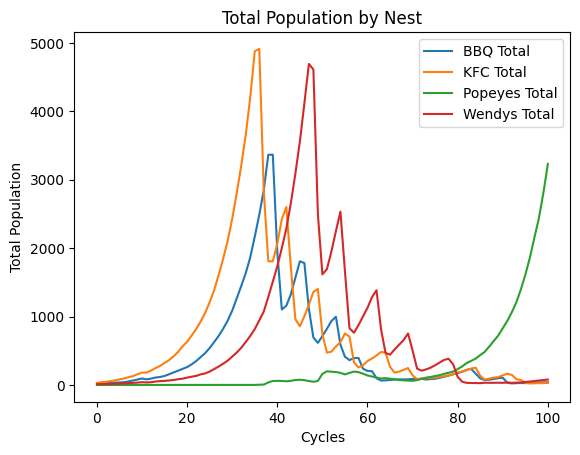

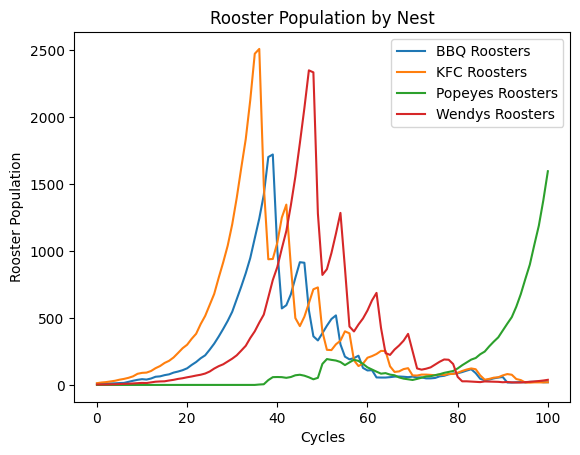

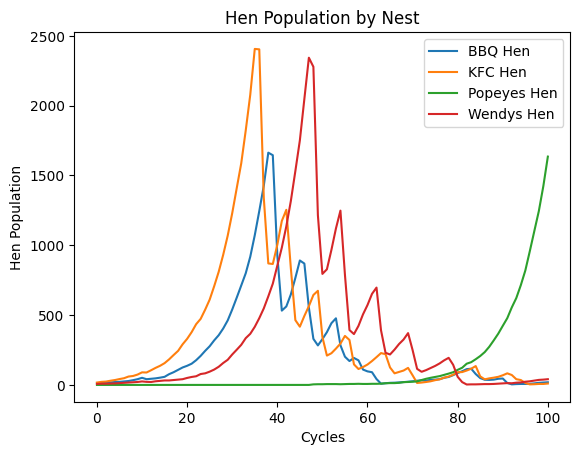

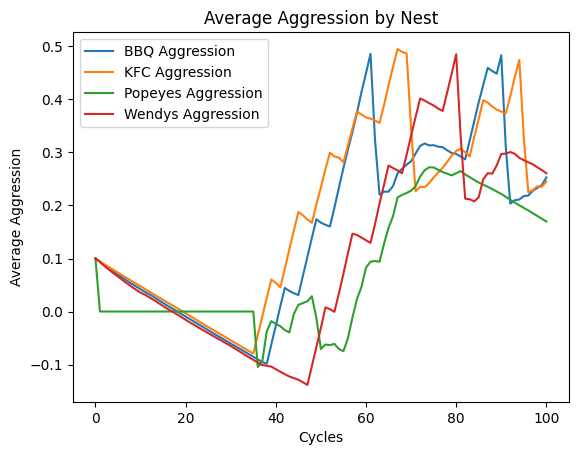

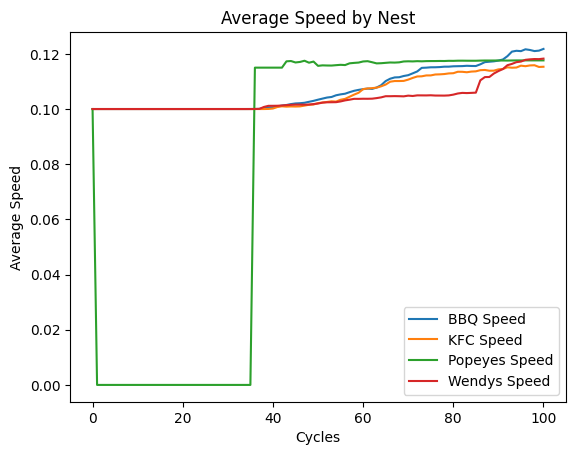

In [137]:
# Assigned a figure number to each data point
total = 1
roosters = 2
hens = 3
aggression = 4
speed = 5

# Plots the chart data.
x = list(range(0, cycles + 1))
for nest in nests:
    plt.figure(total)
    plt.plot(x, nests[nest]["nest"].data.tData, label=f"{nest} Total")        
    plt.figure(roosters)
    plt.plot(x, nests[nest]["nest"].data.rData, label=f"{nest} Roosters")        
    plt.figure(hens)
    plt.plot(x, nests[nest]["nest"].data.hData, label=f"{nest} Hen")        
    plt.figure(aggression)
    plt.plot(x, nests[nest]["nest"].data.agAve, label=f"{nest} Aggression")
    plt.figure(speed)
    plt.plot(x, nests[nest]["nest"].data.spAve, label=f"{nest} Speed")

# Template for future plots
# plt.figure(total)
# plt.legend()
# plt.xlabel("")
# plt.ylabel("")
# plt.title("")

# Total population axis/title label
plt.figure(total)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Total Population")
plt.title("Total Population by Nest")

# Rooster population axis/title label
plt.figure(roosters)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Rooster Population")
plt.title("Rooster Population by Nest")

# Hen population axis/title label
plt.figure(hens)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Hen Population")
plt.title("Hen Population by Nest")

# Average aggression axis/title label
plt.figure(aggression)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Average Aggression")
plt.title("Average Aggression by Nest")

# Average speed axis/title label
plt.figure(speed)
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Average Speed")
plt.title("Average Speed by Nest")

# Show the plots
plt.show()